In [1]:
import mysql.connector as connector
import sklearn
import datetime 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

## SQL Connection & Import

In [4]:
conn = connector.connect(user='root', password='123456', host='localhost', port='3306', database='my_db')

mycursor = conn.cursor()

In [18]:
mycursor.execute('SELECT * FROM price_sentiment')
result = mycursor.fetchall()
df = pd.DataFrame(result, columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock_Splits', 'Score', 'Positive' , 'Negative', 'Neutral', 'Total_Sentiment'])

df.set_index('Date', drop = True, inplace=True)
date = df.index
df.drop(['Open', 'High', 'Low', 'Dividends', 'Stock_Splits', 'Score', 'Positive',	'Negative',	'Neutral'], inplace=True, axis=1)

In [19]:
df

,Close,Volume,Total_Sentiment
Date,,,
2014-01-06,0.374438,409492000.0,0.00000
2014-04-23,0.452159,261580000.0,-1.00000
2015-06-01,0.541710,372660000.0,0.00000
2016-01-05,0.802491,490272000.0,1.00000
2016-09-28,1.642590,319788000.0,0.00000
...,...,...,...
2025-02-10,133.570000,216989000.0,5.84000
2025-02-11,132.800000,178356000.0,3.90909
2025-02-12,131.447000,49444900.0,4.76471


### Data Processing

In [39]:
def calc_updown(data):
    for i in range(1,len(list(data))):

        updown = data[i] - data[i-1]
        
        if updown >=0:
            out = 1
        else:
            out = 0

        return out

In [ ]:
df['Close'] = df['Close'].shift(-1)
df.dropna(inplace=True)



In [32]:
len(df['Close'])

1593

In [36]:
dt =  df['Close']

In [38]:
len(dt)

1593

In [41]:
df['updown'] = (df['Close'].diff() >= 0).astype(int)

In [ ]:
df_date = df.index
df_columns = df.columns
scaler = MinMaxScaler()

df_transformed = scaler.fit_transform(df)
df_transformed = pd.DataFrame(df_transformed)

df_transformed.columns = df_columns
df_transformed.set_index(df_date, inplace=True)


In [8]:
df_transformed.sort_index(inplace=True)

In [9]:
df_transformed.index = pd.to_datetime(df_transformed.index)

In [10]:
temp = df_transformed.loc['2021-01-01':'2025-02-14']

In [11]:
X = temp.drop('Close', axis=1)

In [12]:
Y = temp['Close']

### Function train test split for time series


In [13]:
tscv = TimeSeriesSplit(n_splits=2)

for train_index, test_index in (tscv.split(X)):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

In [14]:
X_train

,Volume,Total_Sentiment
Date,,
2021-01-04,0.140304,0.058968
2021-01-05,0.075015,0.029484
2021-01-06,0.145734,0.049140
2021-01-07,0.113088,0.029484
2021-01-08,0.066717,0.029484
...,...,...
2023-10-12,0.118535,0.110565
2023-10-13,0.116556,0.029484
2023-10-16,0.089380,0.029484


In [68]:
y_train

Date
2021-01-04    0.080872
2021-01-05    0.085759
2021-01-06    0.085308
2021-01-07    0.087618
2021-01-08    0.086702
                ...   
2023-10-10    0.311548
2023-10-11    0.301584
2023-10-12    0.305841
2023-10-13    0.291359
2023-10-16    0.279663
Name: Close, Length: 656, dtype: float64

## Linear Regression

In [15]:
model=LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [16]:
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

mse = mean_squared_error(y_test, y_pred)
print(mse)


-4.52789503188956
0.2844783448441194


In [46]:
import numpy as np

X_data = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = model.predict(X_data)

temp = np.array([[prediction[0], X_data[0, 0], X_data[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

54.47916891943991


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [28]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

In [31]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),  
    ('model', LinearRegression())
])

param_grid = {
    'poly__degree': [1, 2, 3, 4, 5, 6],
    'model__fit_intercept': [True, False]
}

In [50]:
# 🔹 Perform Grid Search
grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1  # Using R² as the metric
)

grid_search.fit(X, Y)  # Flatten Y to 1D array

print(f"Best Polynomial Degree: {grid_search.best_params_['poly__degree']}")
print(f"Best R² Score: {grid_search.best_score_:.4f}")

Best Polynomial Degree: 1
Best R² Score: -37.9102


## Decision Tree

In [55]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(r2)

mse = mean_squared_error(y_test, y_pred)
print(mse)

-14.21872352352714
9032.662508488274


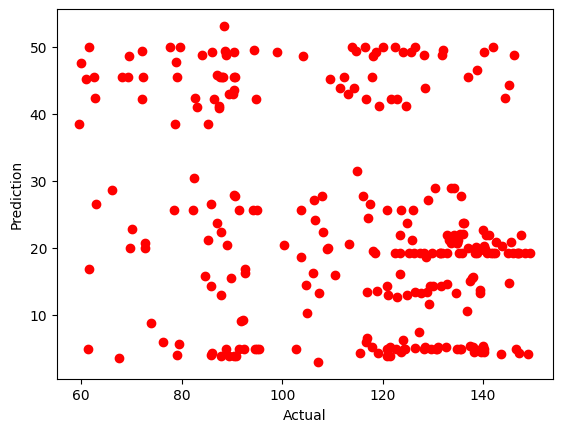

In [56]:
plt.scatter(y_test,y_pred, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [ ]:
import numpy as np

X_data = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = dt.predict(X_data )

temp = np.array([[prediction[0], X_data[0, 0], X_data[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

2869.1992608642


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [59]:
parameter ={
    'max_depth': [10,20,30,None],
    'min_samples_split': [2,5,10],
    'min_samples_leaf':[1,2,4]
}

grid_search = GridSearchCV(estimator=dt, param_grid=parameter, cv=5,n_jobs=-1,  scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(mse)

8154.635495177609


In [ ]:
import numpy as np

X_data = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = dt.predict(X_data)

temp = np.array([[prediction[0], X_data[0, 0], X_data[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

2869.1992608642


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [ ]:
X_data = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = best_dt.predict(X_data)

temp = np.array([[prediction[0], X_data[0, 0], X_data[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

4939.74376132584


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


## Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)

r2 = r2_score(y_test,rf_pred)
print(r2)

mse = mean_squared_error(rf_pred, y_test)
print(mse)

-13.21173540465526
8434.991894802068


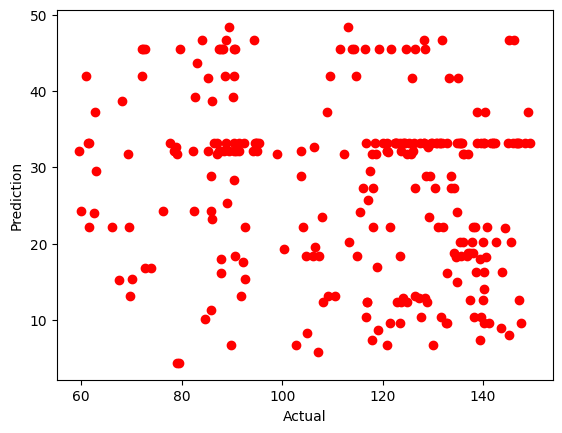

In [63]:
plt.scatter(y_test,y_pred, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()

In [ ]:
X_data = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = rf.predict(X_data)

temp = np.array([[prediction[0], X_data[0, 0], X_data[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

3850.8052122582517


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [67]:
parameter ={
    'n_estimators':[100,200,300,400,500],
    'max_depth': [2,5,10,20,30, None],
    'min_samples_split':[2,5,10,20,30],
    'min_samples_leaf':[1,2,5,10,20,30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=parameter,cv=5,n_jobs=-1,scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)


{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 30, 'n_estimators': 100}


In [68]:
best_rf = grid_search.best_estimator_

rf_pred = best_rf.predict(X_test)

mse = mean_squared_error(rf_pred, y_test)
print(mse)

8468.060984897322


In [ ]:
X_data = df_transformed.drop('Close', axis=1).iloc[-1].to_numpy().reshape(1, -1)

prediction = best_rf .predict(X_data)

temp = np.array([[prediction[0], X_data[0, 0], X_data[0, 1]]])

original_value = scaler.inverse_transform(temp)

print(original_value[0,0])

4375.449693918858


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [70]:
df_transformed.index = pd.to_datetime(df_transformed.index)

df_transformed.index = df_transformed.index.strftime('%d-%m-%Y')

## LSTM (TBC)

In [51]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

In [52]:
dnn = Sequential()
dnn.add(Dense(units=128, activation = 'relu', input_dim=2))
dnn.add(Dense(units=32, activation = 'relu'))
dnn.add(Dense(units=8, activation = 'relu'))
dnn.add(Dense(units=1, activation = 'linear'))

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
dnn.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
es = EarlyStopping(monitor='val_loss', mode = 'min',verbose=1, patience=200)

In [55]:
history = dnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0614 - val_loss: 0.5807
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0321 - val_loss: 0.3882
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.4137
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0221 - val_loss: 0.3955
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0213 - val_loss: 0.3823
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - val_loss: 0.3834
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186 - val_loss: 0.3590
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179 - val_loss: 0.3584
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0167 - val_loss: 0.3565
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 - val_loss: 0.3676
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - val_loss: 0.3442
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [ ]:
prediction = dnn.predict(X_test) 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[[0.7900622 ]
 [0.31037137]
 [0.32326582]
 [0.49980053]
 [0.5560725 ]
 [0.43532535]
 [0.38071647]
 [0.54376805]
 [0.6618596 ]
 [0.7645227 ]
 [0.47720623]
 [0.41430646]
 [0.5575623 ]
 [0.40986118]
 [0.17349313]
 [0.30643505]
 [0.76512927]
 [0.41738024]
 [0.56777304]
 [0.2218404 ]
 [0.22175269]
 [0.6368039 ]
 [0.17562151]
 [0.28983465]
 [0.2979531 ]
 [0.15909535]
 [0.6760359 ]
 [0.21831284]
 [0.2974287 ]
 [0.1840935 ]
 [0.22375222]
 [0.20823403]
 [0.18039796]
 [0.4923861 ]
 [0.14251128]
 [0.17033778]
 [0.4129757 ]
 [0.292825  ]
 [0.17717256]
 [0.18806553]
 [0.2199874 ]
 [0.17744717]
 [0.17415376]
 [0.41468862]
 [0.4920597 ]
 [0.14092612]
 [0.18290295]
 [0.18162002]
 [0.13700235]
 [0.21562375]
 [0.17628936]
 [0.48945853]
 [0.2925506 ]
 [0.385373  ]
 [0.77241915]
 [0.21955912]
 [0.1376658 ]
 [0.1263921 ]
 [0.16122222]
 [0.15882985]
 [0.15194853]
 [0.1378625 ]
 [0.15312904]
 [0.17727995]
 [0.17801213]
 [0.22486927]
 [0.1416796 ]
 [0.18547854]
 [0.180537

In [59]:
from sklearn.metrics import r2_score

print(r2_score(y_test,prediction))

-53.62403929536398


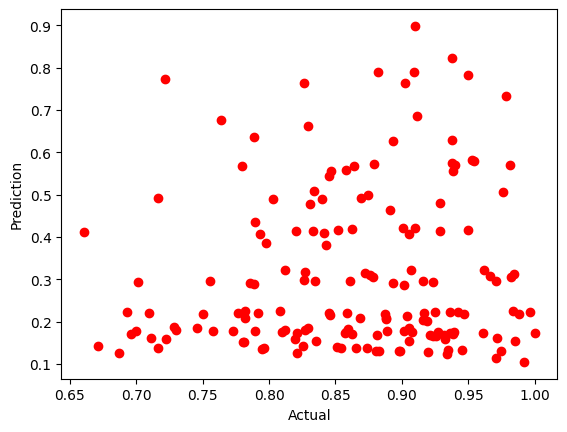

In [60]:
import matplotlib.pyplot as plt

plt.scatter(y_test,prediction, color='red')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.show()